In [87]:
# Paquetes
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

In [88]:
data = pd.read_csv("datasets/demanda.csv",index_col="TIPO", parse_dates=True, dayfirst=True)

In [89]:
data.tail()

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
TIPO,,,,
2018-04-01,4.084.110,3.131.427,3.277.777,10.493.315
2018-05-01,4.276.830,3.101.854,3.286.778,10.665.462
2018-06-01,5.569.775,3.231.036,3.123.287,11.924.098
2018-07-01,6.167.114,3.326.186,3.112.541,12.605.842
2018-08-01,5.359.054,3.237.765,3.112.882,11.709.701


In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44 entries, 2015-01-01 to 2018-08-01
Data columns (total 4 columns):
Residencial                    44 non-null object
Comercial                      44 non-null object
Industrial/Comercial Grande    44 non-null object
TOTAL                          44 non-null object
dtypes: object(4)
memory usage: 1.7+ KB


In [91]:
# Vamos a transformar los object en int
data.Residencial = data.Residencial.apply(lambda x : str(x).replace(".","")).astype(int)
data.Comercial = data.Comercial.apply(lambda x : str(x).replace(".","")).astype(int)
data["Industrial/Comercial Grande"] = data["Industrial/Comercial Grande"].apply(lambda x : str(x).replace(".","")).astype(int)
data.TOTAL = data.TOTAL.apply(lambda x : str(x).replace(".","")).astype(int)

In [92]:
# Veamos si funciono
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44 entries, 2015-01-01 to 2018-08-01
Data columns (total 4 columns):
Residencial                    44 non-null int64
Comercial                      44 non-null int64
Industrial/Comercial Grande    44 non-null int64
TOTAL                          44 non-null int64
dtypes: int64(4)
memory usage: 1.7 KB


In [93]:
data.tail()

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
TIPO,,,,
2018-04-01,4084110,3131427,3277777,10493315
2018-05-01,4276830,3101854,3286778,10665462
2018-06-01,5569775,3231036,3123287,11924098
2018-07-01,6167114,3326186,3112541,12605842
2018-08-01,5359054,3237765,3112882,11709701


In [94]:
data.describe()

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
count,4.400000e+01,4.400000e+01,4.400000e+01,4.400000e+01
mean,4.745018e+06,3.193531e+06,3.201239e+06,1.113979e+07
std,6.270953e+05,1.937162e+05,1.070309e+05,7.643435e+05
min,3.754330e+06,2.900824e+06,2.950818e+06,9.793759e+06
25%,4.222957e+06,3.038991e+06,3.122472e+06,1.046609e+07
50%,4.715576e+06,3.151394e+06,3.215652e+06,1.112625e+07
75%,5.201443e+06,3.312378e+06,3.266523e+06,1.180056e+07
max,6.167114e+06,3.670275e+06,3.460880e+06,1.260584e+07


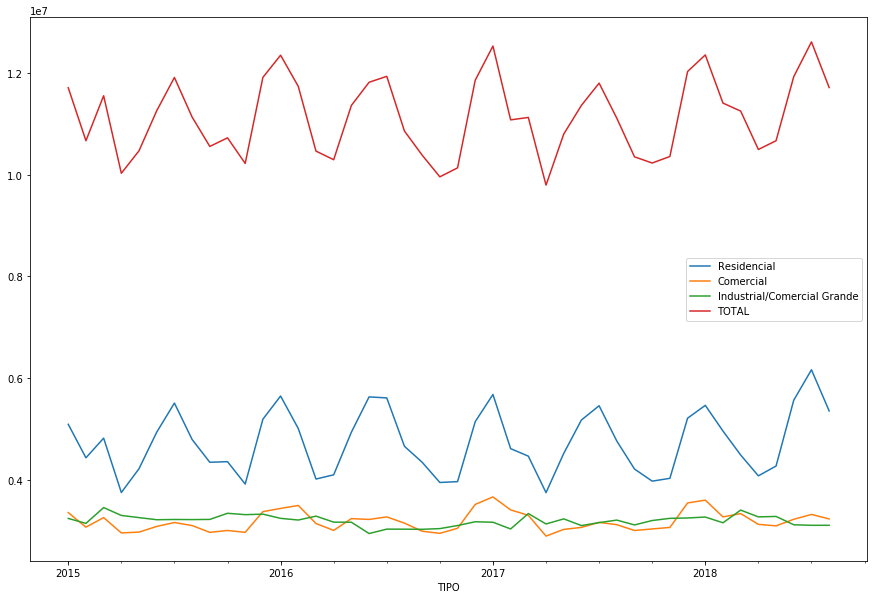

In [95]:
data.plot(figsize=(15,10))

In [96]:
y = data.TOTAL.copy()
y.index = y.index.to_period(freq="M")
y.head()

TIPO
2015-01    11706190
2015-02    10665087
2015-03    11548527
2015-04    10026435
2015-05    10467634
Freq: M, Name: TOTAL, dtype: int64

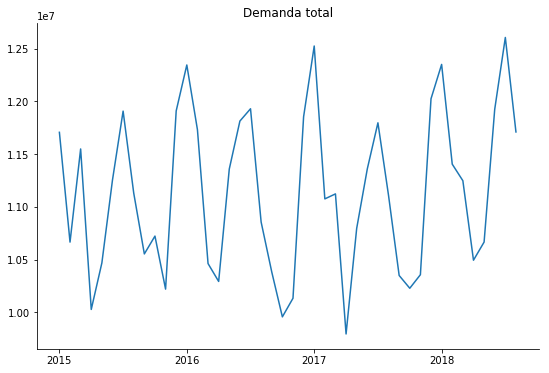

In [97]:
fig, ax= plt.subplots(figsize=(9,6))
y.plot()
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Demanda total')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

In [98]:
# Voy a probar la descomposición
ts = data['TOTAL']
decomposition = sm.tsa.x13_arima_analysis(ts,x12path='.')
dir(decomposition)[-6:]

['observed', 'plot', 'results', 'seasadj', 'stdout', 'trend']

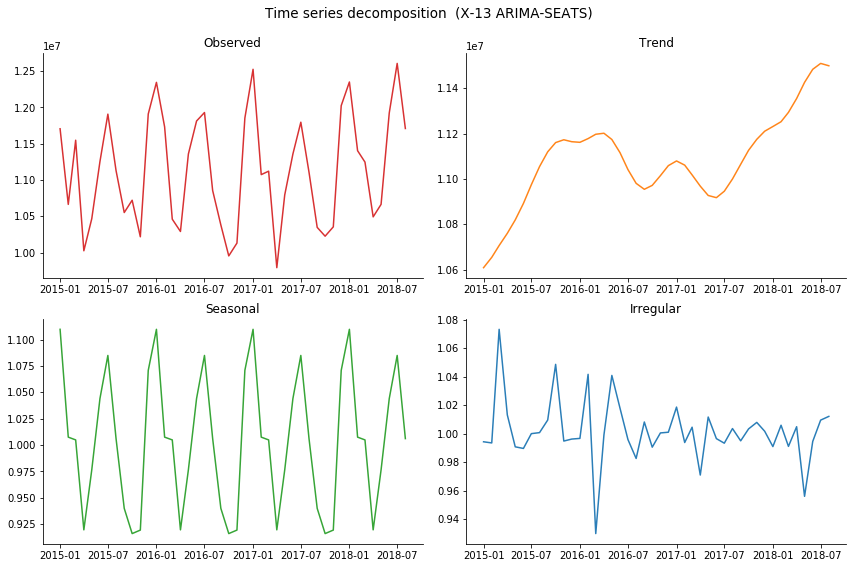

In [99]:
from plotting import plot_components_x13
plot_components_x13(decomposition)
plt.show()

Vemos que la componente seasonal es la predominante

In [100]:
ts=decomposition.seasadj
ts.index=ts.index.to_period(freq='M')

In [101]:
ts.head()

TIPO
2015-01    1.054864e+07
2015-02    1.058526e+07
2015-03    1.149212e+07
2015-04    1.090224e+07
2015-05    1.071950e+07
Freq: M, Name: seasadj, dtype: float64

In [102]:
def holt_winter_values(model_sm):
    alpha_sm = model_sm.model.params['smoothing_level']
    betha_sm = model_sm.model.params['smoothing_slope']
    delta_sm = model_sm.model.params['smoothing_seasonal']
    mse_sm = sm.tools.eval_measures.mse(model_sm.data.endog,model_sm.fittedvalues)
    rmse_sm = sm.tools.eval_measures.rmse(model_sm.data.endog,model_sm.fittedvalues)
    print(' Smoothing parameter: alpha  {0:.3f}'.format(alpha_sm))
    print(' Smoothing parameter: betha  {0:.3f}'.format(betha_sm))
    print(' Smoothing parameter: delta  {0:.3f}'.format(delta_sm))
    print(' In-sample fit:')
    print(' MSE               {0:.3f}'.format(mse_sm))
    print(' RMSE               {0:.3f}'.format(rmse_sm))

In [103]:
def plot_holt(model_sm):
    smoothed=pd.Series(model_sm.fittedvalues, index=y.index)
    fig, ax= plt.subplots(figsize=(9,6))
    y['2014':].plot(color='#D62728', label='Total demand')
    smoothed['2014':].plot(color='black', label='Smoothed', alpha=0.6)
    plt.legend(loc='best')
    ax.set_xlabel('')
    ax.set_xticks([], minor=True)
    ax.set_title(r'Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
    sns.despine()
    plt.show()

In [104]:
model1 = sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()

In [105]:
holt_winter_values(model1)

 Smoothing parameter: alpha  0.053
 Smoothing parameter: betha  0.053
 Smoothing parameter: delta  0.421
 In-sample fit:
 MSE               152389189756.988
 RMSE               390370.580


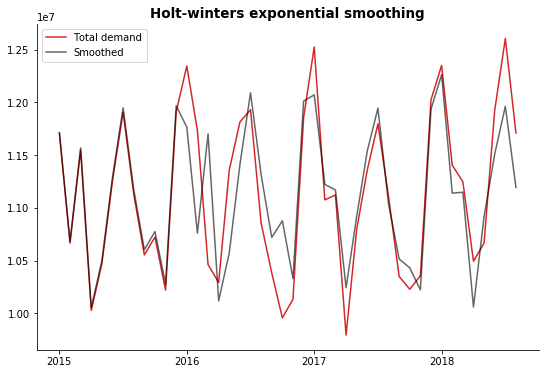

In [106]:
plot_holt(model1)

In [107]:
model2 = sm.tsa.ExponentialSmoothing(y, trend='mul', damped=True, seasonal='mul', seasonal_periods=12).fit()

In [108]:
holt_winter_values(model2)

 Smoothing parameter: alpha  0.053
 Smoothing parameter: betha  0.053
 Smoothing parameter: delta  0.421
 In-sample fit:
 MSE               125990079147.986
 RMSE               354950.812


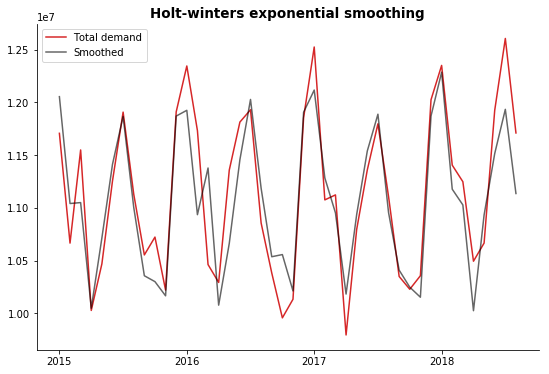

In [109]:
plot_holt(model2)

In [110]:
model3  = sm.tsa.ExponentialSmoothing(y, trend='add', damped=True, seasonal='add', seasonal_periods=12).fit()

In [111]:
holt_winter_values(model3)

 Smoothing parameter: alpha  0.053
 Smoothing parameter: betha  0.053
 Smoothing parameter: delta  0.421
 In-sample fit:
 MSE               152389189756.988
 RMSE               390370.580


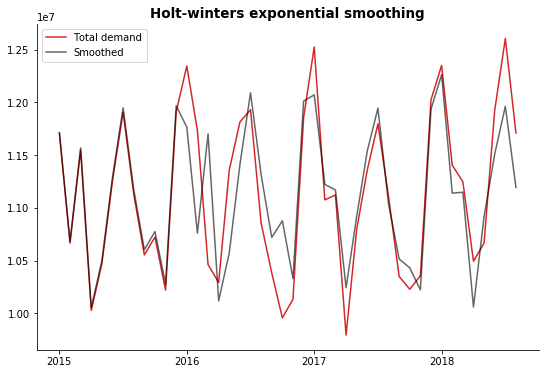

In [112]:
plot_holt(model3)

In [113]:
model4 = sm.tsa.ExponentialSmoothing(y, trend='mul', damped=True, seasonal='add', seasonal_periods=12).fit()

In [114]:
holt_winter_values(model4)

 Smoothing parameter: alpha  0.053
 Smoothing parameter: betha  0.053
 Smoothing parameter: delta  0.947
 In-sample fit:
 MSE               185005099208.198
 RMSE               430122.191


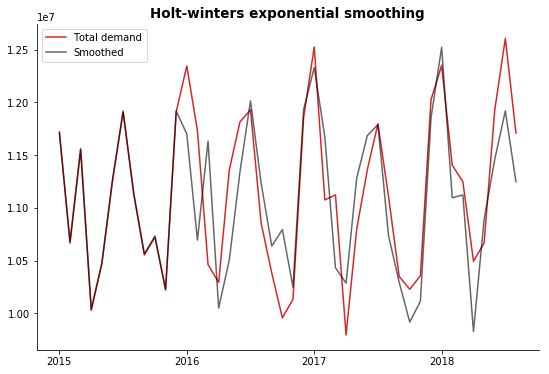

In [115]:
plot_holt(model4)

In [116]:
model5 = sm.tsa.ExponentialSmoothing(y, trend='add', damped=True, seasonal='mul', seasonal_periods=12).fit()

In [117]:
holt_winter_values(model5)

 Smoothing parameter: alpha  0.053
 Smoothing parameter: betha  0.053
 Smoothing parameter: delta  0.421
 In-sample fit:
 MSE               122864419866.758
 RMSE               350520.213


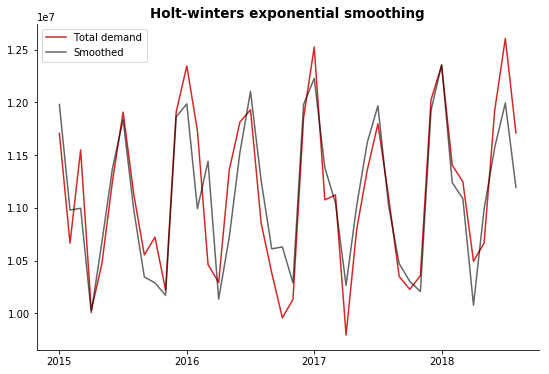

In [118]:
plot_holt(model5)

Vemos que model 5,es el que menor RMSE posee, por ende es el que usare para predecir. El model 5 usa el trend aditivo y el seasonal multiplicativo con damped en True.  

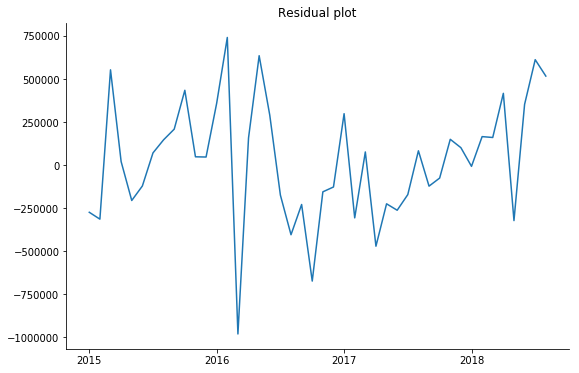

In [121]:
resid = (y-model5.fittedvalues) # we remove the first 12 observations as they are for initialisitation only
blue='#1F77B4'
fig, ax= plt.subplots(figsize=(9,6))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

Los residuos se ven bien

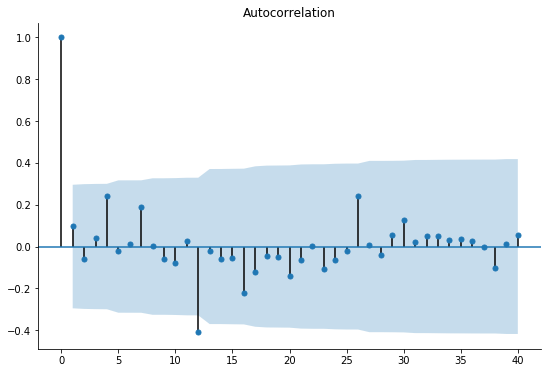

In [122]:
fig, ax = plt.subplots(figsize=(9,6))
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax)
sns.despine()
plt.show()

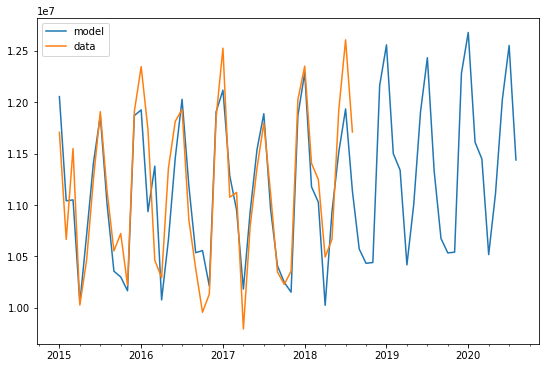

In [120]:
h=24 #significa que predecire a dos años.
forecast = model5.forecast(h)
plot = pd.DataFrame()
plot['model'] = pd.concat([model2.fittedvalues, forecast])
plot['data'] = y
plot['2010':].plot(figsize=(9,6));